In [4]:
# imports
import os
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.io import read_image
import torch.nn as nn
import torch
from torch import tensor
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets.utils import download_url
from sklearn.preprocessing import LabelEncoder
from torch import nn
import seaborn as sns
from torchvision import models

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [6]:
csv_filepath='/kaggle/input/data/Data_Entry_2017.csv'
train_filepath='/kaggle/input/data/train_val_list.txt'
test_filepath='/kaggle/input/data/test_list.txt'
img_path="/kaggle/input/data"

## Data Loading

In [7]:
class XRayClassifier(nn.Module):
    """
    Base CheXNet model, modified to fit constrained classification task.
    State dict must be loaded to initialize model from DenseNet to CheXNet pretrained state.
    ie. use XRayClassifier.load_state_dict(get_chexnet_state(),strict=False)
    """
    def __init__(self, out_size):
        super(XRayClassifier, self).__init__()
        self.densenet121 = models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 14),
            nn.ReLU(),
            nn.Linear(14,out_size), #out_size should be 5 for this application
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x
    
# function to get state dict for the CheXNet Model
def get_chexnet_state(path='./model.pth.tar',map_to=device):
    '''
    Modify given CheXNet state dictionary to fit the modified architecture.
    Returns a state dict which can be passed to XRayClassifier model
    
    NOTE: Set strict=False when passing to load_state_dict method.
    '''
    checkpoint = torch.load(path, map_location=map_to)
    substring = 'module.'
    state = checkpoint['state_dict']
    new_state = {}

    for old_key in state.keys():
        new_key = old_key[len(substring):] if old_key.startswith(substring) else old_key
        new_key = new_key.replace('norm.1', 'norm1')
        new_key = new_key.replace('conv.1', 'conv1')
        new_key = new_key.replace('norm.2', 'norm2')
        new_key = new_key.replace('conv.2', 'conv2')
        new_state[new_key] = state[old_key] 

    return new_state

In [8]:
def trainer(model, criterion, optimizer, trainloader, device, epochs=5):
    model.to(device)
    train_loss = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            y_hat = model(X)
            loss  = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(trainloader)
        train_loss.append(avg_loss)
        print(f"Epoch {epoch+1} — Average Loss: {avg_loss:.4f}")

    return train_loss

def validator(model, criterion, optimizer, validloader, device):
    # Validation
    model.eval()
    valid_loss = []
    preds = []
    actual = []
    valid_batch_loss = 0
    
    model.to(device)
    with torch.no_grad():  # This stops pytorch doing computational graph stuff under-the-hood

        for X_valid, y_valid in validloader:
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            y_hat = model(X_valid)  # Forward pass to get output
            loss = criterion(y_hat, y_valid)  # Calculate loss based on output
            valid_batch_loss += loss.item()
            preds.append(y_hat.clone().detach())
            actual.append(y_valid.clone().detach())
        
    valid_loss.append(valid_batch_loss / len(validloader))
    return valid_loss, preds, actual

In [9]:
# function to get training and testing data
def get_train_test_data(
    csv_filepath=csv_filepath,
    train_filepath=train_filepath,
    test_filepath=test_filepath
    ):
  all_images = pd.read_csv(csv_filepath)
  train_ids = pd.read_csv(train_filepath,sep=' ',header=None,names=['Image Index'])
  test_ids = pd.read_csv(test_filepath,sep=' ',header=None,names=['Image Index'])
  train_data = pd.merge(all_images,train_ids,how='inner')
  test_data = pd.merge(all_images,test_ids,how='inner')

  return train_data,test_data
train_df, test_df = get_train_test_data()

In [10]:
def remove_multiple_labels(df):
    df2 = df["Finding Labels"].str.split("|",expand=True)
    for i in range(1,6):
        df2.loc[df2[i] == "Mass", 0] = "Mass"
        df2.loc[~ df2[i].isna(), 0] = "Drop"

    df['Finding Labels'] = df2[0]
    df = df[df["Finding Labels"] != "Drop"]
    return df

train_df = remove_multiple_labels(train_df)
test_df = remove_multiple_labels(test_df)

In [11]:
def remove_no_findings(df):
    df2 = df[df["Finding Labels"] != "No Finding"]
    return df2

train_df = remove_no_findings(train_df)
test_df = remove_no_findings(test_df)

## Exploratory Data Analysis

In [12]:
train_df.describe()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,22971.000000,22971.000000,22971.000000,22971.000000,22971.000000,22971.000000,22971.000000,0.0
mean,5.920204,14513.692438,48.262810,2654.673893,2508.516608,0.155162,0.155162,NaN
std,9.607832,8498.024835,16.624185,337.068921,409.485857,0.016165,0.016165,NaN
min,0.000000,1.000000,1.000000,1282.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7227.500000,37.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,2.000000,14314.000000,51.000000,2544.000000,2544.000000,0.143000,0.143000,NaN
75%,7.000000,21027.000000,60.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,106.000000,30795.000000,154.000000,3266.000000,3056.000000,0.198800,0.198800,NaN


In [13]:
train_df.dtypes

Image Index                     object
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                      int64
Patient Gender                  object
View Position                   object
OriginalImage[Width              int64
Height]                          int64
OriginalImagePixelSpacing[x    float64
y]                             float64
Unnamed: 11                    float64
dtype: object

In [14]:
train_df.isna().any()

Image Index                    False
Finding Labels                 False
Follow-up #                    False
Patient ID                     False
Patient Age                    False
Patient Gender                 False
View Position                  False
OriginalImage[Width            False
Height]                        False
OriginalImagePixelSpacing[x    False
y]                             False
Unnamed: 11                     True
dtype: bool

The column "Unnamed:11" must be removed before plotting with Altair.

In [15]:
train_df=train_df.drop(columns=["Unnamed: 11"])
train_df=train_df.rename(columns={"y]":"y",'OriginalImagePixelSpacing[x':'x','OriginalImage[Width':'width','Height]':'height'})
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,width,height,x,y
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
11,00000005_006.png,Infiltration,6,5,70,F,PA,2992,2991,0.143,0.143
15,00000008_000.png,Cardiomegaly,0,8,69,F,PA,2048,2500,0.171,0.171
17,00000008_002.png,Nodule,2,8,73,F,PA,2048,2500,0.168,0.168
18,00000009_000.png,Emphysema,0,9,73,M,PA,2992,2991,0.143,0.143


In [16]:
#aly.dist(train_df)

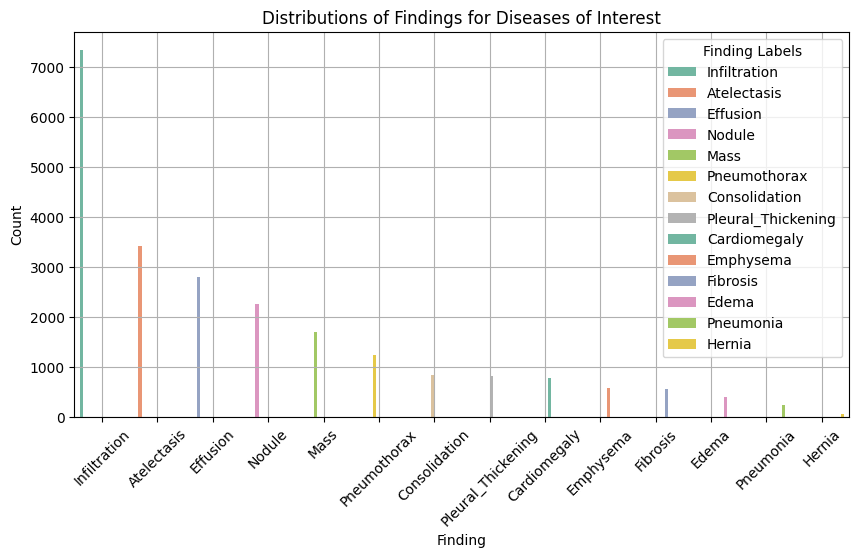

In [17]:
# plot labels and their counts
fig, ax = plt.subplots(figsize=(10, 5))
counts = train_df['Finding Labels'].value_counts()
sns.barplot(x=counts.index, y=counts.values, ax=ax, hue=counts.index, palette="Set2")
ax.set_title("Distributions of Findings for Diseases of Interest")
ax.set_xlabel("Finding")
plt.xticks(rotation=45)
ax.set_ylabel("Count")
ax.grid(True)

plt.show();

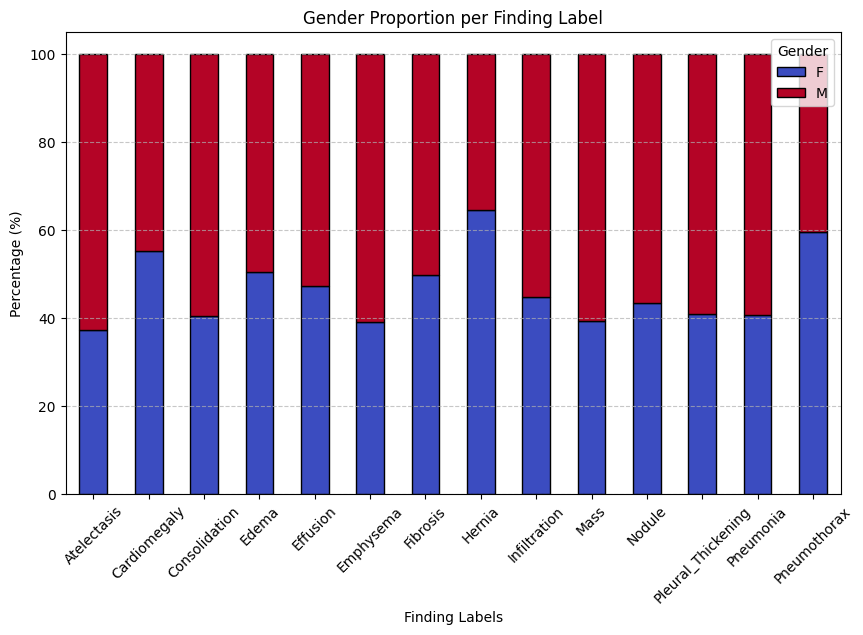

In [18]:
# Get the gender distribution from train_df
gender_distribution = train_df.groupby("Finding Labels")["Patient Gender"].value_counts().unstack(fill_value=0)

# Normalize the counts to percentages
gender_distribution_percent = gender_distribution.div(gender_distribution.sum(axis=1), axis=0) * 100

# Plot 100% stacked bar chart
gender_distribution_percent.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="coolwarm", edgecolor="black")

# Labels and title
plt.xlabel("Finding Labels")
plt.ylabel("Percentage (%)")
plt.title("Gender Proportion per Finding Label")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show Plot
plt.show();

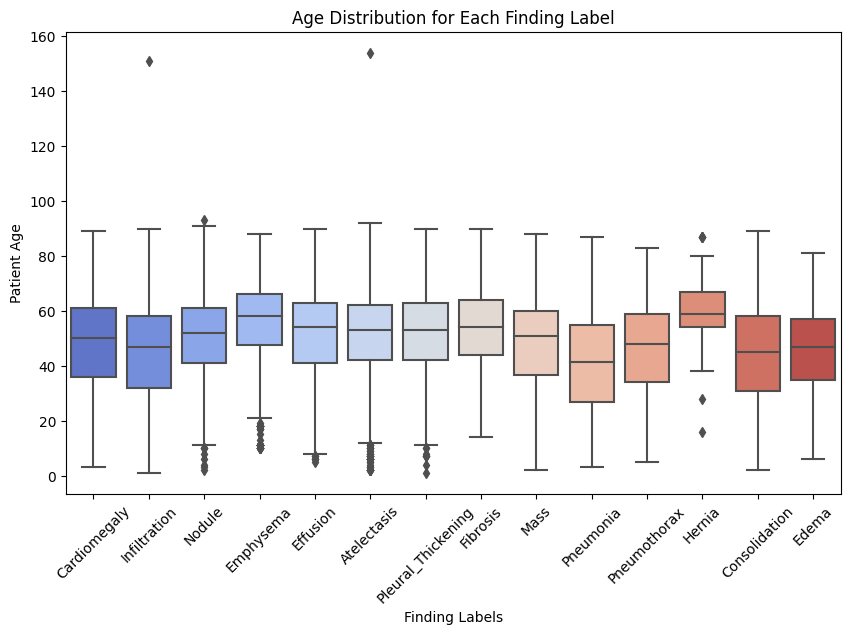

In [19]:
# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Finding Labels", y="Patient Age", data=train_df, palette="coolwarm")

# Customization
plt.xlabel("Finding Labels")
plt.ylabel("Patient Age")
plt.title("Age Distribution for Each Finding Label")
plt.xticks(rotation=45)

# Show plot
plt.show();

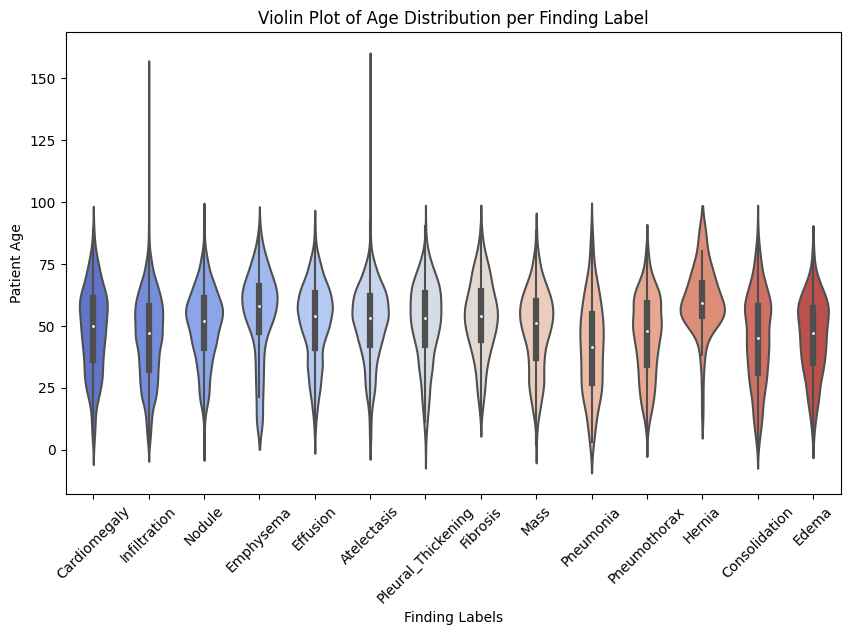

In [20]:
# Remove invalid ages (greater than 300)
filtered_df = train_df[train_df["Patient Age"] <= 300]

# Plot Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x="Finding Labels", y="Patient Age", data=filtered_df, palette="coolwarm")

# Labels & Title
plt.xlabel("Finding Labels")
plt.ylabel("Patient Age")
plt.title("Violin Plot of Age Distribution per Finding Label")
plt.xticks(rotation=45)

# Show Plot
plt.show()



## Preprocessing

We have multiple labels per observation.

* Atelectasis
* Cardiomegaly
* Effusion
* Infiltration
* Mass
* Nodule
* Pneumonia
* Pneumothorax
* Consolidation
* Edema
* Emphysema
* Fibrosis
* Pleural_Thickening
* Hernia

"Mass" is difficult to detect, therefore if there any "multiple-diagnoses" with this label, we made the observation solely "Mass". All other multiple-diagnoses was disregarded. From the EDA, it is seen that there are a large number of "No Finding" observations. 

As such, it was decided to limit this label to about 7000 oberservations for computational efficiency of the training set. Additionally, we will only look at predicting the following diseases due to their difficulty to detect. This decision is based on this information from [this](https://pmc.ncbi.nlm.nih.gov/articles/PMC10154905/) article.

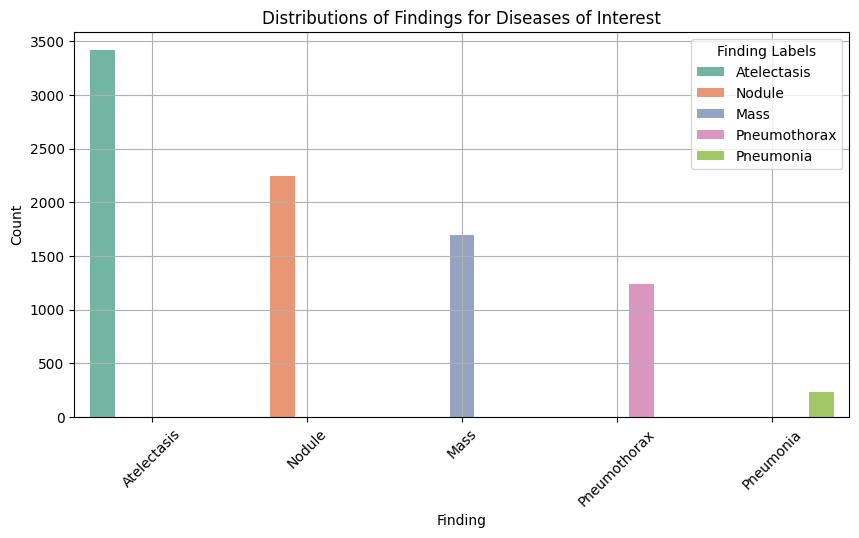

In [21]:
labels_to_keep = ["Nodule",
                  "Mass",
                  "Pneumonia",
                  "Pneumothorax",
                  "Atelectasis",
                  "No Finding"]

train_df = train_df[train_df["Finding Labels"].isin(labels_to_keep)]

# plot labels and their counts
fig, ax = plt.subplots(figsize=(10, 5))
counts = train_df['Finding Labels'].value_counts()
sns.barplot(x=counts.index, y=counts.values, ax=ax, hue=counts.index, palette="Set2")
ax.set_title("Distributions of Findings for Diseases of Interest")
ax.set_xlabel("Finding")
plt.xticks(rotation=45)
ax.set_ylabel("Count")
ax.grid(True)

plt.show();

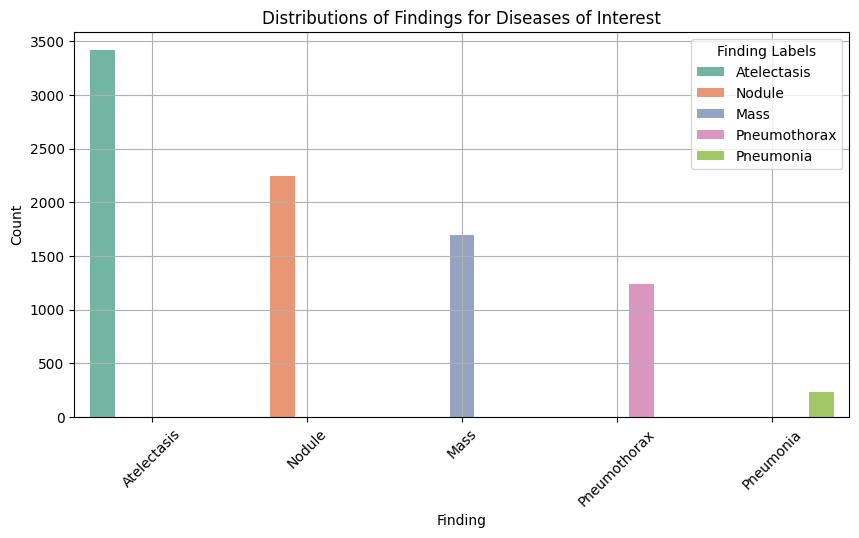

In [22]:
# plot labels and their counts
fig, ax = plt.subplots(figsize=(10, 5))
counts = train_df['Finding Labels'].value_counts()
sns.barplot(x=counts.index, y=counts.values, ax=ax, hue=counts.index, palette="Set2")
ax.set_title("Distributions of Findings for Diseases of Interest")
ax.set_xlabel("Finding")
plt.xticks(rotation=45)
ax.set_ylabel("Count")
ax.grid(True)

plt.show();

In [23]:
test_df = test_df[test_df["Finding Labels"].isin(labels_to_keep)]
test_df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
19,00000013_011.png,Pneumothorax,11,13,60,M,AP,3056,2544,0.139000,0.139000,NaN
20,00000013_012.png,Pneumothorax,12,13,60,M,AP,3056,2544,0.139000,0.139000,NaN
21,00000013_013.png,Pneumothorax,13,13,60,M,AP,3056,2544,0.139000,0.139000,NaN
28,00000013_020.png,Pneumothorax,20,13,62,M,PA,2021,2021,0.194311,0.194311,NaN
32,00000013_024.png,Mass,24,13,57,M,AP,2500,2048,0.168000,0.168000,NaN


## Training

The model will be trained using the Transfer Learning model: XRayClassifier. CrossEntropyLoss will be used as the loss function and optimizer Adam.

## Data Loader

In [24]:
names=["001","002","003","004","005","006","007","008","009","010","011","012"]

In [25]:

class ImageFolder(Dataset):
    def __init__(self, data, img_dir, transform=None, target_transform=None):
       # self.img_labels = pd.read_csv(annotations_file,sep=' ',header=None,names=['Image Index'])
        self.imgs = data
        self.labels=data["Finding Labels"]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # image = read_image("/kaggle/input/data/images_001/images/00000001_000.png")
        for i in names:
            try:
                name=f"{self.img_dir}/images_{i}/images"
                img_pth = os.path.join(name, self.imgs.iloc[idx, 0])
                image = read_image(img_pth)
                break;
            except:
                continue;
        label = self.imgs.iloc[idx, 1]
        label = self.label_encoder.transform([label])[0]  # Transformed label as numeric
        label = torch.tensor(label, dtype=torch.int64)

        
        if self.transform:
             image = self.transform(image)
        if self.target_transform:
             label = self.target_transform(label)
        return image, label

In [59]:
transform_train = v2.Compose([
    v2.Resize((150,150)),
    v2.PILToTensor(),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    lambda img: img[:3, :, :] if img.shape[0] == 4 else img,    
    v2.Grayscale(num_output_channels=3),
    # v2.RandomHorizontalFlip(),
    # v2.RandomVerticalFlip()
    
])

In [60]:
train=ImageFolder(train_df,img_path,transform=transform_train)
test=ImageFolder(test_df,img_path, transform=transform_train)

In [61]:
batch_size=128
train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
test_dl=DataLoader(test, batch_size=batch_size, shuffle=False)
display_dl=DataLoader(train, batch_size=32)

In [62]:
i,k=train[114]
i.shape

torch.Size([3, 150, 150])

images.shape: torch.Size([32, 3, 150, 150])


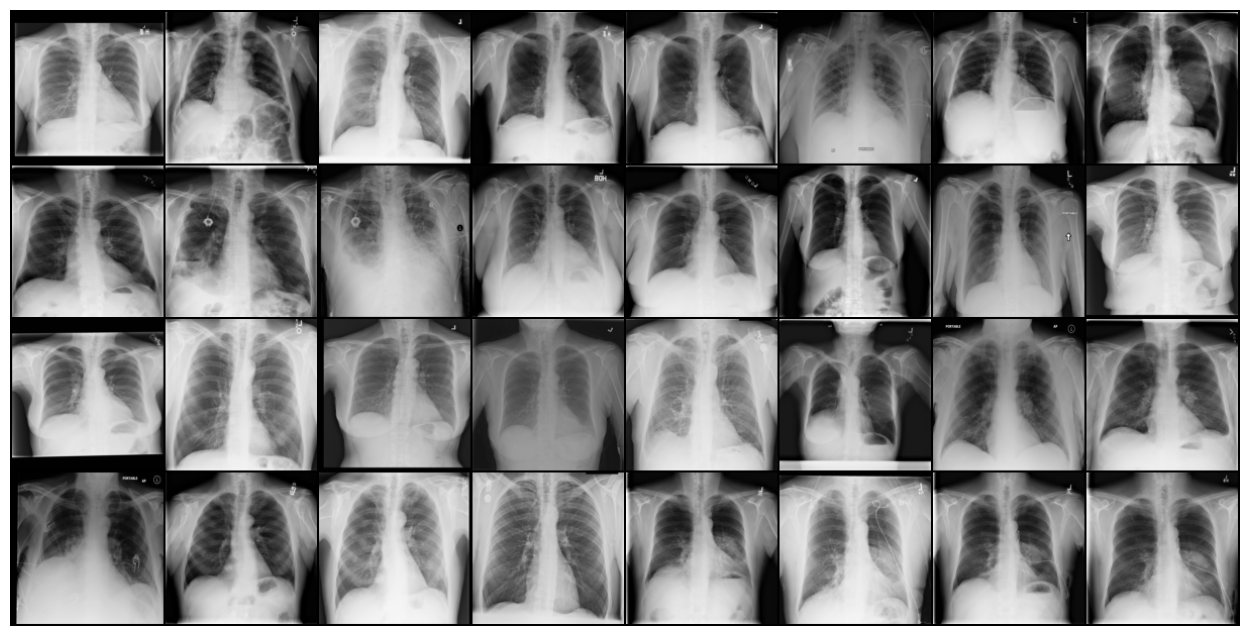

In [63]:
for u,_ in display_dl:
    print('images.shape:', u.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(u, nrow=8).permute((1, 2, 0)))
    break

In [65]:
import warnings
warnings.filterwarnings("ignore")

model = XRayClassifier(out_size=5)
model.load_state_dict(state_dict=get_chexnet_state(path='/kaggle/input/xrayclassifier/other/default/1/model.pth.tar'),strict=False)
for param in model.densenet121.parameters():
    param.requires_grad = False

for param in model.densenet121.classifier[-2:].parameters():
    param.requires_grad = True

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
train_loss = trainer(model, criterion, optimizer, train_dl, device, epochs=5)

Epoch 1 — Average Loss: 1.5071
Epoch 2 — Average Loss: 1.4174
Epoch 3 — Average Loss: 1.3934
Epoch 4 — Average Loss: 1.3800
Epoch 5 — Average Loss: 1.3629


In [69]:
torch.save(model.state_dict(), '/kaggle/working/my_model.pth')

In [70]:
model.load_state_dict(torch.load('/kaggle/working/my_model.pth', weights_only=True))
valid_loss, predictions, actual = validator(model, criterion, optimizer, test_dl, device)
print(f"The validation loss is {valid_loss}.")

The validation loss is [1.37589031457901].


In [71]:
predictions[0][:4]

tensor([[6.4462e-01, 2.5965e-02, 6.5972e-03, 6.8686e-07, 9.9965e-01],
        [1.2048e-03, 7.7038e-01, 1.4237e-03, 1.2074e-07, 9.9982e-01],
        [7.8469e-01, 8.9015e-02, 2.2168e-02, 3.0586e-06, 9.9978e-01],
        [3.8349e-03, 2.4332e-01, 1.3911e-03, 3.3570e-07, 9.9997e-01]],
       device='cuda:0')

In [72]:
actual[0][:4]

tensor([4, 4, 4, 4], device='cuda:0')

In [74]:
from torcheval.metrics.functional import multiclass_auroc
from torcheval.metrics import MulticlassF1Score,MulticlassPrecision,MulticlassRecall

def get_metrics(predictions, target):
    # Initialize metric objects
    f1 = MulticlassF1Score(num_classes=5)
    recall = MulticlassRecall(num_classes=5)
    precision = MulticlassPrecision(num_classes=5)

    # Update metrics with predictions and targets
    f1.update(predictions, target)
    recall.update(predictions, target)
    precision.update(predictions, target)

    # Compute AUROC
    auc = multiclass_auroc(predictions, target, num_classes=5)

    # Print the computed metric values
    print(f'F1 Score: {f1.compute()}')
    print(f'Recall: {recall.compute()}')
    print(f'Precision: {precision.compute()}')
    print(f'AUC: {auc}')

get_metrics(torch.cat(predictions), torch.cat(actual))

F1 Score: 0.5142232179641724
Recall: 0.5142232179641724
Precision: 0.5142232179641724
AUC: 0.6984869837760925


Predicted class: Nodule
Actual class: Nodule


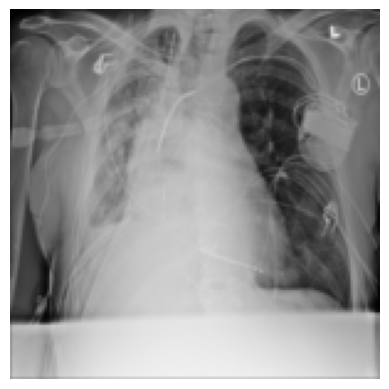

Predicted class: Atelectasis
Actual class: Pneumothorax


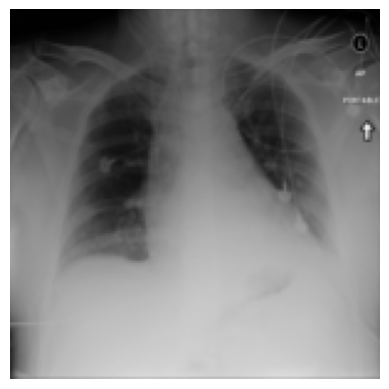

Predicted class: Pneumothorax
Actual class: Nodule


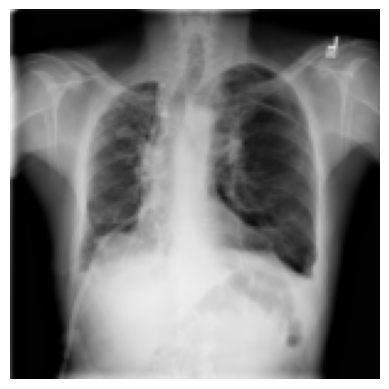

Predicted class: Pneumothorax
Actual class: Atelectasis


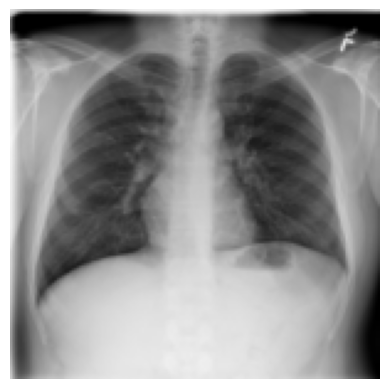

Predicted class: Mass
Actual class: Mass


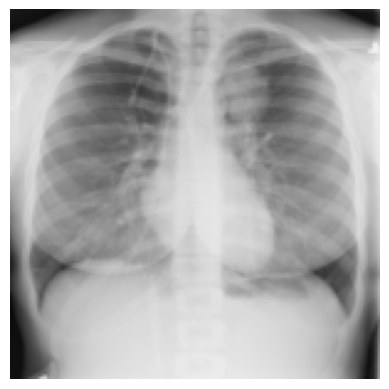

Predicted class: Pneumothorax
Actual class: Pneumothorax


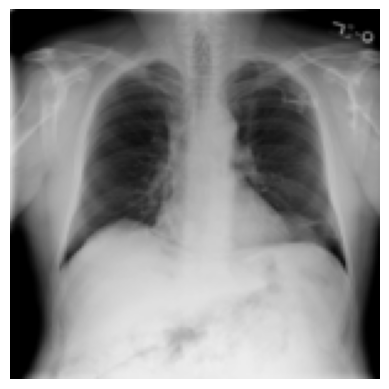

Predicted class: Nodule
Actual class: Pneumothorax


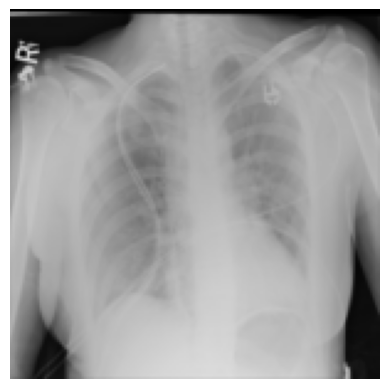

Predicted class: Atelectasis
Actual class: Atelectasis


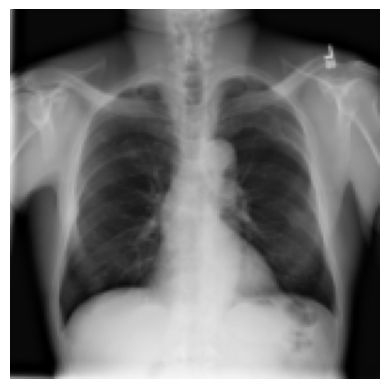

Predicted class: Mass
Actual class: Pneumothorax


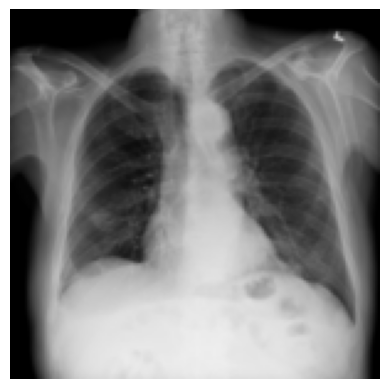

Predicted class: Atelectasis
Actual class: Pneumothorax


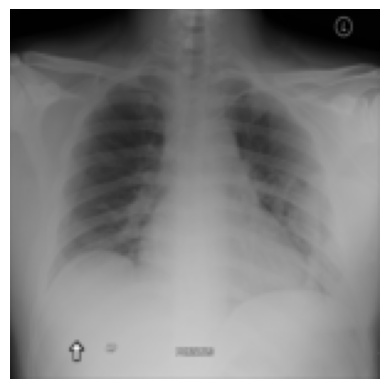

In [88]:
model.eval()
classes=test_df["Finding Labels"].unique().tolist()
display_max = 10
shown = 0

with torch.no_grad():
    for img, target in test_dl:
        if shown >= display_max:
            break
        shown += 1
        
        out = model(img.to(device))         
        pred_idx  = out.argmax(dim=1)[0].item()
        true_idx  = target[0].item()
        
        print(f"Predicted class: {classes[pred_idx]}")
        print(f"Actual class: {classes[true_idx]}")
        plt.imshow(img[0].permute(1,2,0).cpu())
        plt.axis("off")
        plt.show();